In [1]:
# import sys
# import requests

# !{sys.executable} -m pip install git+https://github.com/facebookresearch/segment-anything.git
    
# url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
# r = requests.get(url)

# with open("sam_vit_h_4b8939.pth", "wb") as f:
#     f.write(r.content)

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from ultralytics import YOLO, settings
import shutil

print("CUDA is available:", torch.cuda.is_available())

CUDA is available: True


In [22]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_image(image, ax='Off', figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis(ax)
    plt.show()

def show_image_with_box(image, box):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_box(box, plt.gca())
    plt.axis('off')
    plt.show()

def show_image_with_boxes_and_masks(image_rgb, boxes, masks):
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    for mask in masks:
        show_mask(mask.cpu().numpy(), plt.gca())
    for box in boxes:
        show_box(box.cpu().numpy(), plt.gca())
    plt.axis('off')
    plt.show()

In [4]:
MODEL_PATH_PLANT = '../models/plant_detection_v2.pt'
settings.update({'runs_dir': rf'C:\Users\buyse\Workspace\NTNU\models\runs'})
model_plant = YOLO(MODEL_PATH_PLANT)

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

sam_checkpoint = "../models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [6]:
IMG_PATH_FIXED = '../images/cropped_scales/fixed'
IMG_PATH_RANDOM = '../images/cropped_scales/random'

if not os.path.exists(IMG_PATH_FIXED):
    print("Error, no fixed images found")
    exit(1)

if not os.path.exists(IMG_PATH_RANDOM):
    print("Error, no random images found")
    exit(1)

images = [os.path.join(IMG_PATH_FIXED, f) for f in os.listdir(IMG_PATH_FIXED) if f.endswith('.jpg') and 'only' not in f and 'grid' not in f]
images += [os.path.join(IMG_PATH_RANDOM, f) for f in os.listdir(IMG_PATH_RANDOM) if f.endswith('.jpg') and 'only' not in f and 'grid' not in f]

images = images[:10]

In [7]:
shutil.rmtree(settings['runs_dir'], ignore_errors=True)
results = model_plant(images, verbose=False)

In [8]:
output = []

for result in results:
    image_path = result.path
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = result.boxes.xyxy

    transformed_boxes = predictor.transform.apply_boxes_torch(boxes, image.shape[:2])

    predictor.set_image(image)

    masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
    )

    output.append({'image_path': image_path, 'image': image, 'boxes': boxes, 'masks': masks})

Show all the images with bounding boxes and masks

In [15]:
def draw_right_half_contours(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert to HSV (Hue, Saturation, Value) color space for easier color segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define range of bright colors in HSV
    lower_color = np.array([0, 100, 100])
    upper_color = np.array([179, 255, 255])

    # Threshold the HSV image to get only bright colors
    mask = cv2.inRange(hsv, lower_color, upper_color)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours that are not our boxes
    box_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]

    # Calculate bounding boxes for each contour
    bounding_boxes = [cv2.boundingRect(cnt) for cnt in box_contours]

    # Determine the midpoint of the image width
    midpoint = image.shape[1] / 2

    # Keep only the boxes that have an x-coordinate greater than the midpoint
    right_half_boxes = [box for box in bounding_boxes if box[0] > midpoint]

    # Sort these boxes by their x-coordinate to ensure rightmost first
    sorted_right_half_boxes = sorted(right_half_boxes, key=lambda x: x[0], reverse=True)

    # Draw these seven boxes on the image
    for (x, y, w, h) in sorted_right_half_boxes:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Calculate the total width in pixels of these seven boxes
    total_width_in_pixels = sum([box[2] for box in sorted_right_half_boxes])

    # Since 7 boxes = 4.5 cm, calculate the pixels per cm
    pixels_per_cm = total_width_in_pixels / 5.79

    print(f"Image: {image_path}\nPixels per cm: {pixels_per_cm}")
    
    # Show the image with the seven boxes drawn
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

    return pixels_per_cm

Image: ../images/cropped_scales/fixed\1699348130.jpg
Size: W: 3385 H: 5844


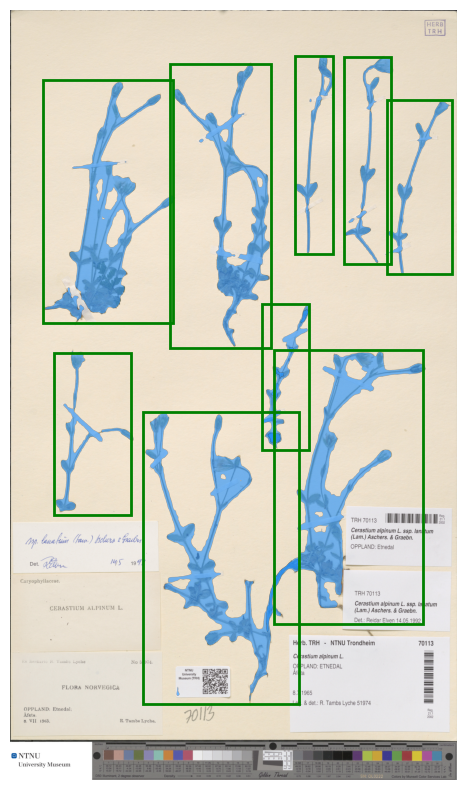

Image: ../images/cropped_scales/fixed\1699348130_scale_only.jpg
Pixels per cm: 115.37132987910189


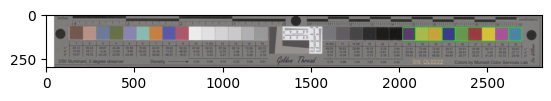

Box with coords: [251.64108276367188, 527.2319946289062, 1237.1473388671875, 2375.67041015625] has:
Width: 8.54 cm
Height: 16.02 cm


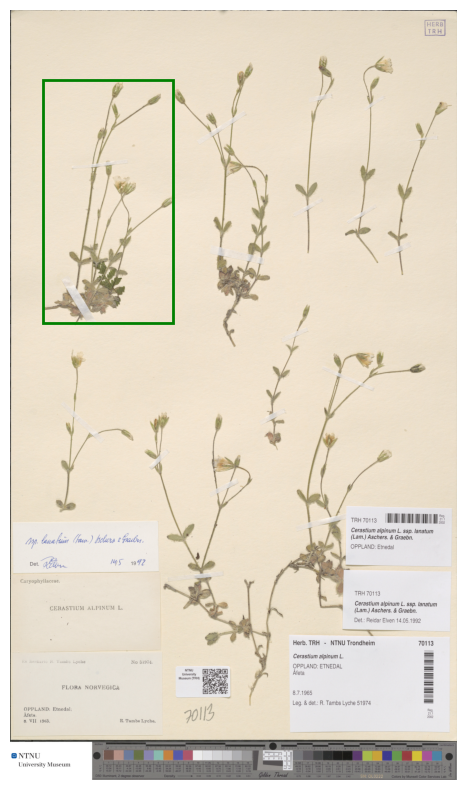

Box with coords: [1215.29736328125, 411.598388671875, 1979.6939697265625, 2562.45703125] has:
Width: 6.63 cm
Height: 18.64 cm


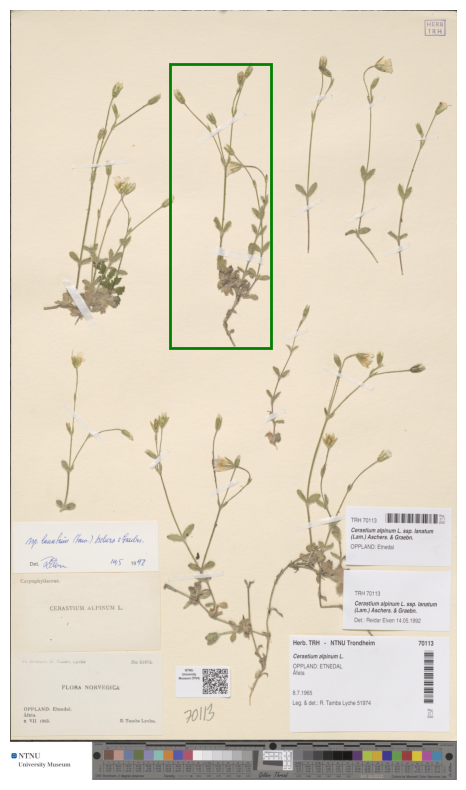

Box with coords: [1008.167724609375, 3052.5048828125, 2191.249267578125, 5266.93115234375] has:
Width: 10.25 cm
Height: 19.19 cm


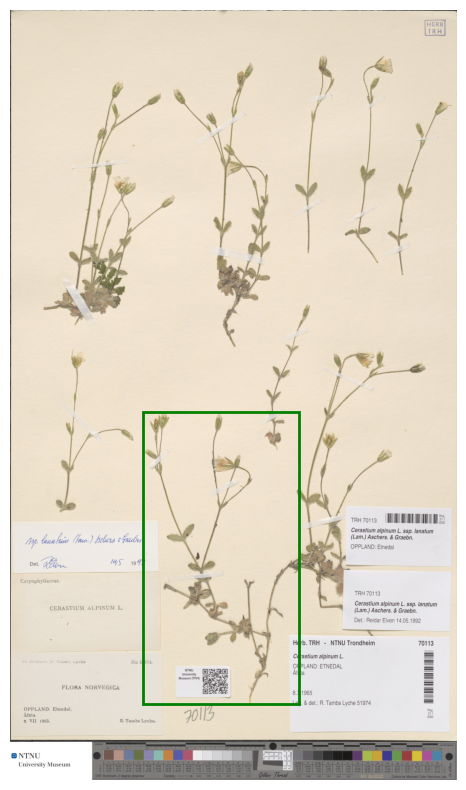

Box with coords: [330.72540283203125, 2603.93896484375, 921.2434692382812, 3833.67822265625] has:
Width: 5.12 cm
Height: 10.66 cm


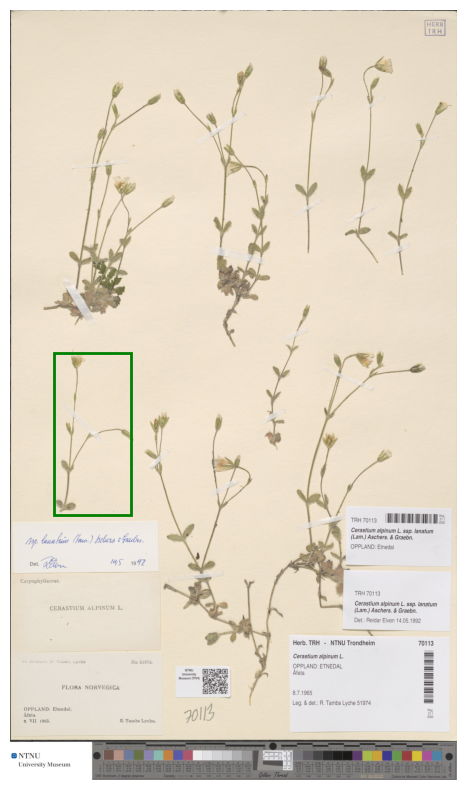

Box with coords: [1908.38232421875, 2233.834716796875, 2272.064453125, 3337.128662109375] has:
Width: 3.15 cm
Height: 9.56 cm


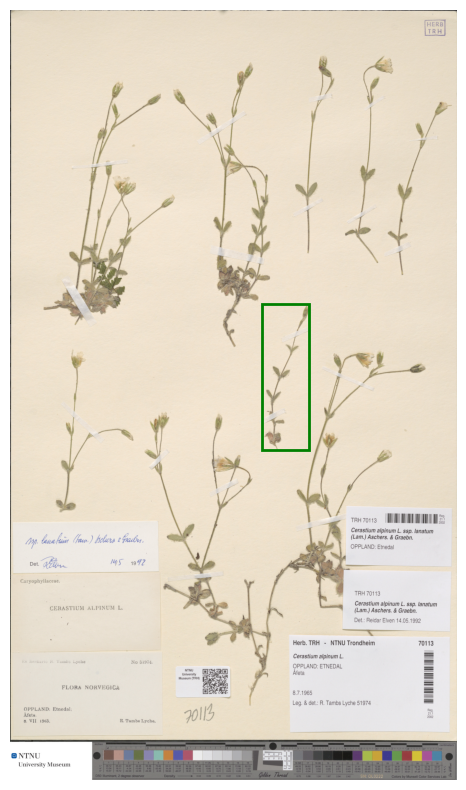

Box with coords: [2862.81201171875, 686.01123046875, 3351.478759765625, 2001.7030029296875] has:
Width: 4.24 cm
Height: 11.40 cm


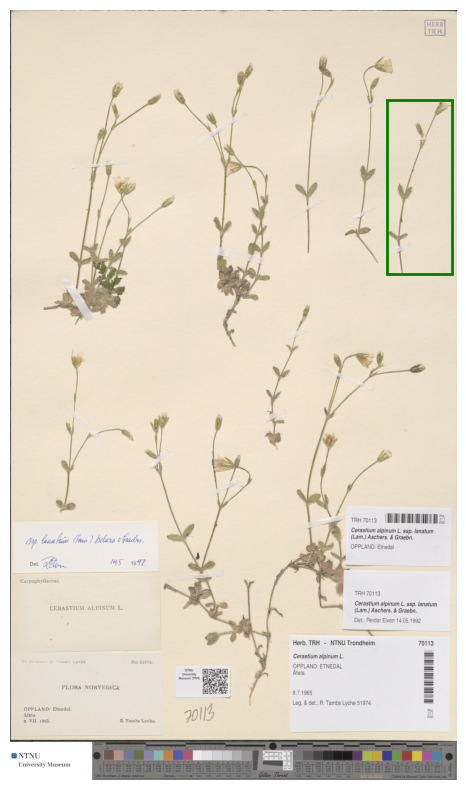

Box with coords: [2160.125, 350.0538024902344, 2448.413818359375, 1853.8358154296875] has:
Width: 2.50 cm
Height: 13.03 cm


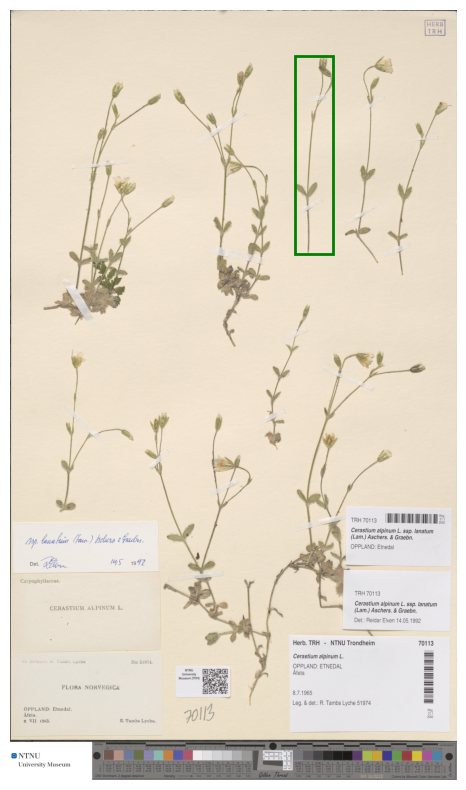

Box with coords: [2005.6812744140625, 2578.373291015625, 3130.55126953125, 4660.21533203125] has:
Width: 9.75 cm
Height: 18.04 cm


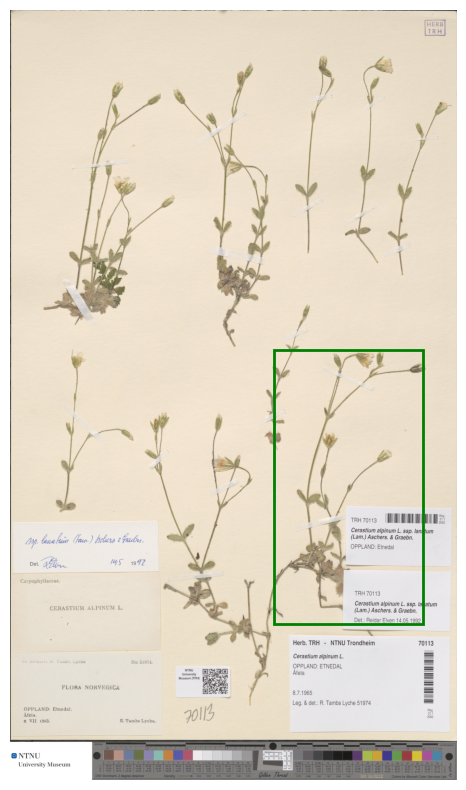

Box with coords: [2532.2880859375, 353.38409423828125, 2892.963623046875, 1930.7408447265625] has:
Width: 3.13 cm
Height: 13.67 cm


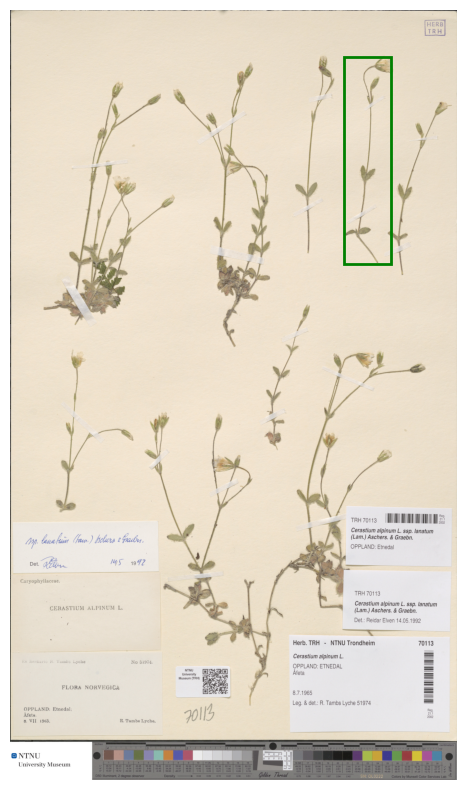

In [24]:
for i, res in enumerate(output[2:3]):
    path = res['image_path']
    w, h = res['image'].shape[1], res['image'].shape[0]
    print(f'Image: {path}\nSize: W: {w} H: {h}')
    show_image_with_boxes_and_masks(res['image'], res['boxes'], res['masks'])
    
    # look for cropped scale
    scale_path = path.replace('.jpg', '_scale_only.jpg')
    px_per_cm = draw_right_half_contours(scale_path)

    # define width and height of the image in cm per box
    for box in res['boxes']:
        w = np.abs((box[2] - box[0]).cpu())
        h = np.abs((box[3] - box[1]).cpu())
        print(f"Box with coords: {box.tolist()} has:\nWidth: {w / px_per_cm:.2f} cm\nHeight: {h / px_per_cm:.2f} cm")
        show_image_with_box(res['image'], box.cpu())

    print("="*150)
    print("="*150)
    print("="*150)
    print()